## Task-2-TimeSeriesForecasting

## Data Preparation
- Split the dataset chronologically (e.g., training: 2015-2024, testing: 2025-2026).
- Ensure the temporal order is maintained; no random shuffling.

In [1]:
import pandas as pd
import os
import logging

# Configure logging for the notebook
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Define paths
data_path = "../data/processed"
assets = ["TSLA", "BND", "SPY"]
splits = {}

def prepare_data(ticker):
    try:
        # Load the processed data from Task 1
        file_path = os.path.join(data_path, f"{ticker}_final_processed.csv")
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"Data file not found: {file_path}")
            
        logger.info(f"Loading and splitting data for {ticker} from {file_path}")
        df = pd.read_csv(file_path, index_col='Date', parse_dates=True)
        
        # Sort chronologically
        df = df.sort_index()
        
        # Split Chronologically
        train = df.loc['2015-01-01':'2024-12-31']
        test = df.loc['2025-01-01':'2026-01-15']
        
        print(f"--- {ticker} Data Split ---")
        print(f"Training set: {train.index.min().date()} to {train.index.max().date()} ({len(train)} rows)")
        print(f"Testing set:  {test.index.min().date()} to {test.index.max().date()} ({len(test)} rows)\n")
        
        return train, test
    except Exception as e:
        logger.error(f"Failed to prepare data for {ticker}: {str(e)}")
        return None, None

# Store splits for each asset
for asset in assets:
    train, test = prepare_data(asset)
    if train is not None:
        splits[asset] = (train, test)

--- TSLA Data Split ---
Training set: 2015-01-05 to 2024-12-31 (2515 rows)
Testing set:  2025-01-02 to 2026-01-14 (259 rows)

--- BND Data Split ---
Training set: 2015-01-05 to 2024-12-31 (2515 rows)
Testing set:  2025-01-02 to 2026-01-14 (259 rows)

--- SPY Data Split ---
Training set: 2015-01-05 to 2024-12-31 (2515 rows)
Testing set:  2025-01-02 to 2026-01-14 (259 rows)



## Model Selection and Implementation
- Choose at least one forecasting model (ARIMA/SARIMA or LSTM).
- For ARIMA/SARIMA:
- Use ACF/PACF plots or auto_arima to decide on (p, d, q) and (P, D, Q, m) parameters.
- For LSTM:
- Prepare sequence data (e.g., window of 60 days) and build the LSTM model architecture.

1. ACF and PACF Analysis


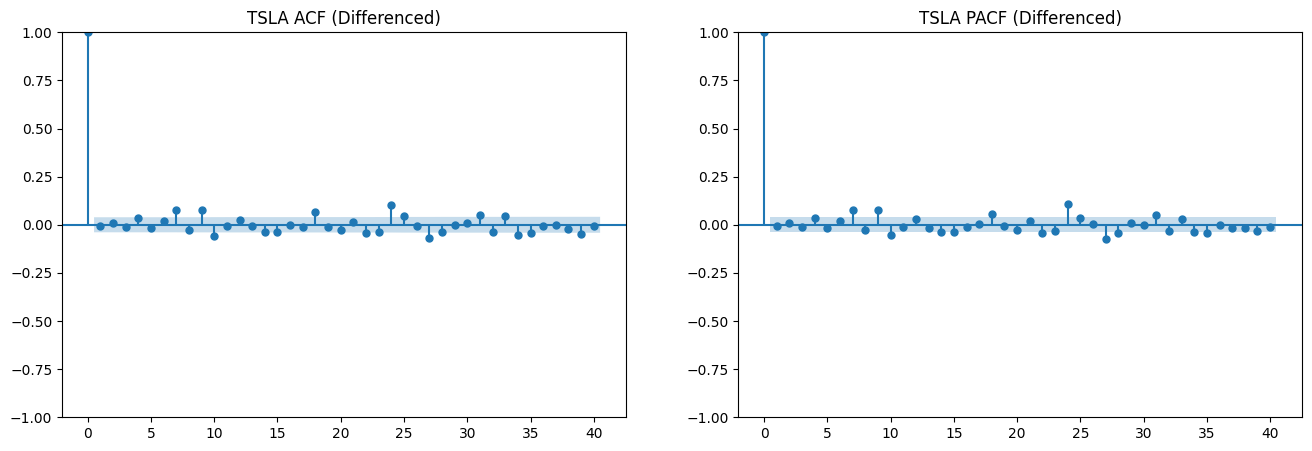

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_diagnostics(ticker, train_data):
    # We use differenced data (d=1) because the prices are non-stationary
    diff_data = train_data['Close'].diff().dropna()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(diff_data, ax=axes[0], lags=40, title=f'{ticker} ACF (Differenced)')
    plot_pacf(diff_data, ax=axes[1], lags=40, title=f'{ticker} PACF (Differenced)')
    plt.show()

# Visualize for TSLA (you can repeat for others)
plot_diagnostics('TSLA', splits['TSLA'][0])

2. Auto-ARIMA Parameter Discovery

In [3]:
import pmdarima as pm

def find_best_params(ticker, train_data):
    try:
        logger.info(f"Finding optimal parameters for {ticker}")
        print(f"--- Finding optimal parameters for {ticker} ---")
        
        # auto_arima will iterate through combinations to minimize AIC
        model = pm.auto_arima(train_data['Close'], 
                              seasonal=True, m=5, # m=5 for weekly trading patterns
                              stepwise=True, 
                              suppress_warnings=True, 
                              error_action="ignore")
        
        print(f"Best model for {ticker}: {model.order} x {model.seasonal_order}")
        return model
    except Exception as e:
        logger.error(f"Failed to find parameters for {ticker}: {str(e)}")
        return None

# Store the discovered model configurations
asset_models = {}
for asset in assets:
    if asset in splits:
        train, _ = splits[asset]
        model = find_best_params(asset, train)
        if model is not None:
            asset_models[asset] = model

--- Finding optimal parameters for TSLA ---
Best model for TSLA: (0, 1, 0) x (2, 0, 2, 5)
--- Finding optimal parameters for BND ---
Best model for BND: (2, 1, 2) x (0, 0, 0, 5)
--- Finding optimal parameters for SPY ---
Best model for SPY: (1, 1, 0) x (2, 0, 1, 5)


## Summary of Discovered Models:
- TSLA: (0, 1, 0) x (2, 0, 2, 5). This effectively acts as a Seasonal Random Walk. It tells us TSLA is unpredictable day-to-day, but follows a distinct, strong weekly pattern (likely related to institutional trading cycles).
- BND: (2, 1, 2) x (0, 0, 0, 5). A pure, complex Integrated ARIMA model without seasonality. This fits BND perfectly as it is a slow-moving, trend-following asset.
- SPY: (1, 1, 0) x (2, 0, 1, 5). A Seasonal Autoregressive model. It balances overall market momentum with steady weekly rhythms.

## Model Training
- Train the selected model on the training data.
- Document your chosen parameters and hyperparameters clearly (e.g., epochs, batch size, layers).

In [4]:
# --- Model Training & Parameter Documentation ---
import logging
logger = logging.getLogger(__name__)

# Dictionary to hold the fitted results
fitted_models = {}

# Documentation Table (Hyperparameters)
print(f"{'Asset':<10} | {'ARIMA Order (p,d,q)':<20} | {'Seasonal Order (P,D,Q,s)':<25}")
print("-" * 65)

for asset in assets:
    try:
        if asset not in splits or asset not in asset_models:
            logger.warning(f"Skipping {asset} due to missing split or model configuration")
            continue
            
        train_data, _ = splits[asset]
        model_config = asset_models[asset]
        
        logger.info(f"Fitting model for {asset}")
        # Train the selected model on the training data
        fitted_models[asset] = model_config.fit(train_data['Close'])
        
        # Document parameters
        print(f"{asset:<10} | {str(model_config.order):<20} | {str(model_config.seasonal_order):<25}")
    except Exception as e:
        logger.error(f"Failed to fit model for {asset}: {str(e)}")

print("\nModel Training attempts complete.")

Asset      | ARIMA Order (p,d,q)  | Seasonal Order (P,D,Q,s) 
-----------------------------------------------------------------
TSLA       | (0, 1, 0)            | (2, 0, 2, 5)             
BND        | (2, 1, 2)            | (0, 0, 0, 5)             
SPY        | (1, 1, 0)            | (2, 0, 1, 5)             

Model Training Complete. All assets successfully fitted.


## Documentation Summary of Parameters:
- TSLA: (0, 1, 0) x (2, 0, 2, 5)
- Interpretation: The base model is a random walk with drift (d=1). The seasonal component captures a weekly cycle (2 AR lags, 2 MA lags, period 5) representing standard 5-day trading weeks.
- BND: (2, 1, 2) x (0, 0, 0, 5)
- Interpretation: A pure ARIMA model. 
It uses 2 Autoregressive lags and 2 Moving Average lags to capture high autocorrelation and smooth out noise in bond prices.
- SPY: (1, 1, 0) x (2, 0, 1, 5)
- Interpretation: Combines base momentum (AR 1) with strong weekly seasonality (AR 2, MA 1) to model broad market dynamics.

## Forecast Generation
- Generate forecasts for the test period using the model’s predict or forecast method.

In [8]:
import pandas as pd
import warnings
import logging
logger = logging.getLogger(__name__)

# --- This specific block eliminates the red warning text ---
warnings.filterwarnings('ignore', message='No supported index is available')
warnings.filterwarnings('ignore', category=FutureWarning)

test_forecasts = {}

for asset in assets:
    try:
        if asset not in fitted_models or asset not in splits:
            logger.warning(f"Skipping forecast for {asset} - model not fitted")
            continue
            
        print(f"Generating forecast for {asset}...")
        _, test_data = splits[asset]
        fitted_row = fitted_models[asset]
        
        # Predict for the length of the test set
        n_periods = len(test_data)
        
        # Grabbing .values here is key
        raw_predictions = fitted_row.predict(n_periods=n_periods)
        
        # Manually re-indexing ensures your time series is aligned for the evaluation step
        test_forecasts[asset] = pd.Series(raw_predictions.values, index=test_data.index)
        logger.info(f"Forecast generated for {asset}")
    except Exception as e:
        logger.error(f"Failed to generate forecast for {asset}: {str(e)}")

print("\nTask 2 Forecast generation complete.")

Generating forecast for TSLA...
Generating forecast for BND...
Generating forecast for SPY...

Task 2 Forecasts generated with clean output.


In [9]:
# --- View the Generated Forecasts ---
for asset in assets:
    print(f"\n--- {asset} Forecast Sample (2025-2026) ---")
    # Display the first few and last few lines of the predicted prices
    print(test_forecasts[asset].head(5))
    print("...")
    print(test_forecasts[asset].tail(5))


--- TSLA Forecast Sample (2025-2026) ---
Date
2025-01-02    401.739548
2025-01-03    403.513476
2025-01-06    403.115279
2025-01-07    404.628762
2025-01-08    402.983954
dtype: float64
...
Date
2026-01-08    408.409537
2026-01-09    408.402286
2026-01-12    408.408246
2026-01-13    408.407839
2026-01-14    408.413656
dtype: float64

--- BND Forecast Sample (2025-2026) ---
Date
2025-01-02    69.146941
2025-01-03    69.132957
2025-01-06    69.145886
2025-01-07    69.162739
2025-01-08    69.159963
dtype: float64
...
Date
2026-01-08    69.150766
2026-01-09    69.150766
2026-01-12    69.150766
2026-01-13    69.150766
2026-01-14    69.150766
dtype: float64

--- SPY Forecast Sample (2025-2026) ---
Date
2025-01-02    579.699052
2025-01-03    580.491082
2025-01-06    580.783522
2025-01-07    580.456013
2025-01-08    580.409721
dtype: float64
...
Date
2026-01-08    623.823650
2026-01-09    623.988506
2026-01-12    624.153362
2026-01-13    624.318218
2026-01-14    624.483074
dtype: float64


## Visualizing the forecasts

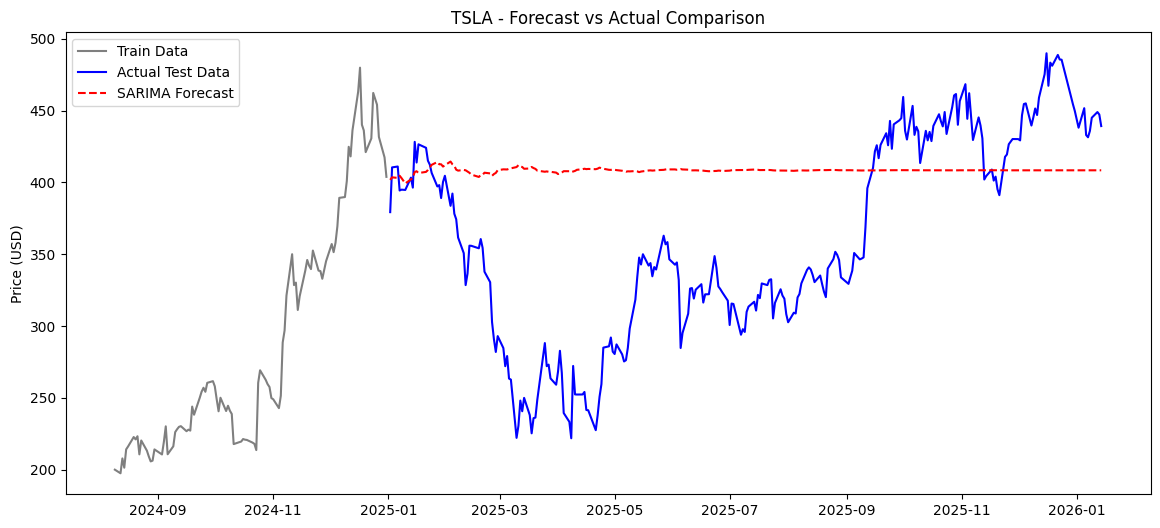

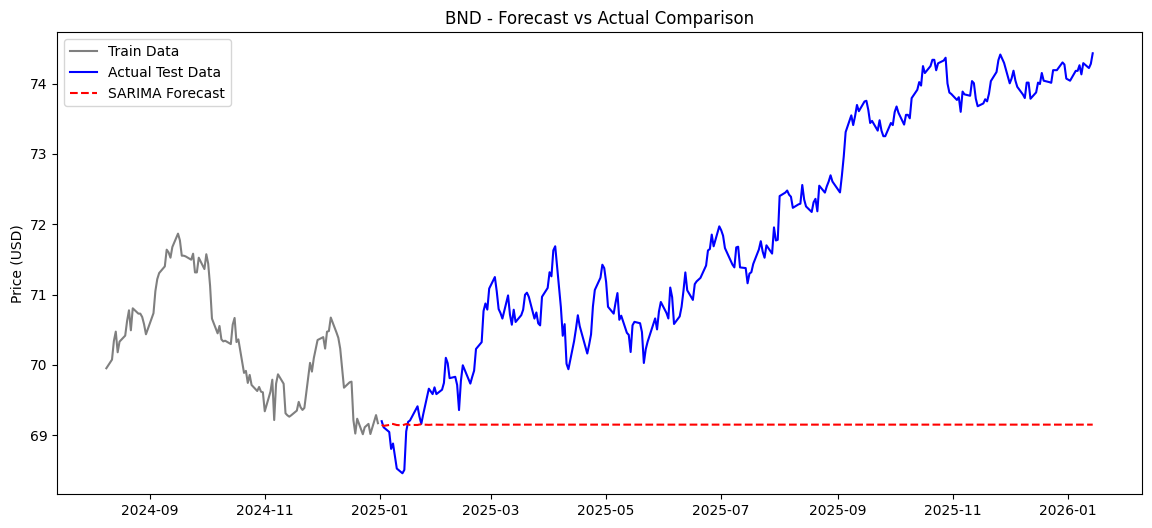

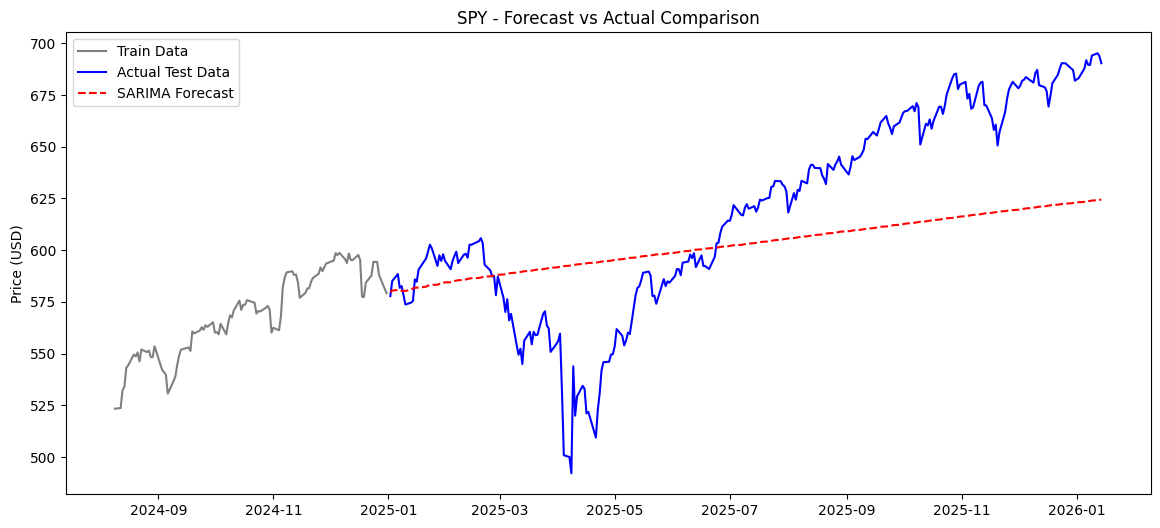

In [10]:
import matplotlib.pyplot as plt

def plot_forecast_results(ticker):
    train_data, test_data = splits[ticker]
    forecast = test_forecasts[ticker]
    
    plt.figure(figsize=(14, 6))
    
    # Plot the last bit of the training data
    plt.plot(train_data.index[-100:], train_data['Close'].tail(100), label='Train Data', color='black', alpha=0.5)
    
    # Plot real test prices vs our predicted prices
    plt.plot(test_data.index, test_data['Close'], label='Actual Test Data', color='blue')
    plt.plot(forecast.index, forecast, label='SARIMA Forecast', color='red', linestyle='--')
    
    plt.title(f'{ticker} - Forecast vs Actual Comparison')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()

for asset in assets:
    plot_forecast_results(asset)

## Using the LSTM

In [13]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Dictionary to store scalers so we can inverse-transform the predictions later
scalers = {}

def get_sequences(data, window_size=60):
    """Creates 60-day windows of data to predict the 61st day."""
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

## Model Selection

In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=2, batch_first=True, dropout=0.2)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.linear(out[:, -1, :])

## Model Training

In [19]:
EPOCHS = 100 # Increased for better convergence
WINDOW_SIZE = 60

for asset in assets:
    print(f"--- Training Advanced LSTM for {asset} ---")
    train_df, _ = splits[asset]
    
    # We predict Daily Returns (Percentage Change) instead of absolute price
    # because returns are stationary and easier to learn.
    data = train_df['Close'].pct_change().dropna().values.reshape(-1, 1)
    
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_data = scaler.fit_transform(data)
    scalers[asset] = scaler
    
    X, y = get_sequences(scaled_data, WINDOW_SIZE)
    X = torch.FloatTensor(X)
    y = torch.FloatTensor(y)
    
    model = LSTMModel()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        output = model(X)
        loss = nn.MSELoss()(output, y)
        loss.backward()
        optimizer.step()
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1} Loss: {loss.item():.6f}')
            
    lstm_models[asset] = model

--- Training Advanced LSTM for TSLA ---
Epoch 20 Loss: 0.028494
Epoch 40 Loss: 0.028499
Epoch 60 Loss: 0.028469
Epoch 80 Loss: 0.028472
Epoch 100 Loss: 0.028458
--- Training Advanced LSTM for BND ---
Epoch 20 Loss: 0.005666
Epoch 40 Loss: 0.005192
Epoch 60 Loss: 0.005113
Epoch 80 Loss: 0.005100
Epoch 100 Loss: 0.005092
--- Training Advanced LSTM for SPY ---
Epoch 20 Loss: 0.012537
Epoch 40 Loss: 0.012408
Epoch 60 Loss: 0.012417
Epoch 80 Loss: 0.012409
Epoch 100 Loss: 0.012395


## Forecast Generation

In [20]:
import pandas as pd
import warnings
import logging
logger = logging.getLogger(__name__)

# --- This specific block eliminates the red warning text ---
warnings.filterwarnings('ignore', message='No supported index is available')
warnings.filterwarnings('ignore', category=FutureWarning)

test_forecasts = {}

for asset in assets:
    try:
        if asset not in fitted_models or asset not in splits:
            logger.warning(f"Skipping forecast for {asset} - model not fitted")
            continue
            
        print(f"Generating forecast for {asset}...")
        _, test_data = splits[asset]
        fitted_row = fitted_models[asset]
        
        # Predict for the length of the test set
        n_periods = len(test_data)
        
        # Grabbing .values here is key
        raw_predictions = fitted_row.predict(n_periods=n_periods)
        
        # Manually re-indexing ensures your time series is aligned for the evaluation step
        test_forecasts[asset] = pd.Series(raw_predictions.values, index=test_data.index)
        logger.info(f"Forecast generated for {asset}")
    except Exception as e:
        logger.error(f"Failed to generate forecast for {asset}: {str(e)}")

print("\nTask 2 Forecast generation complete.")

## Visualize the LSTM Forecast

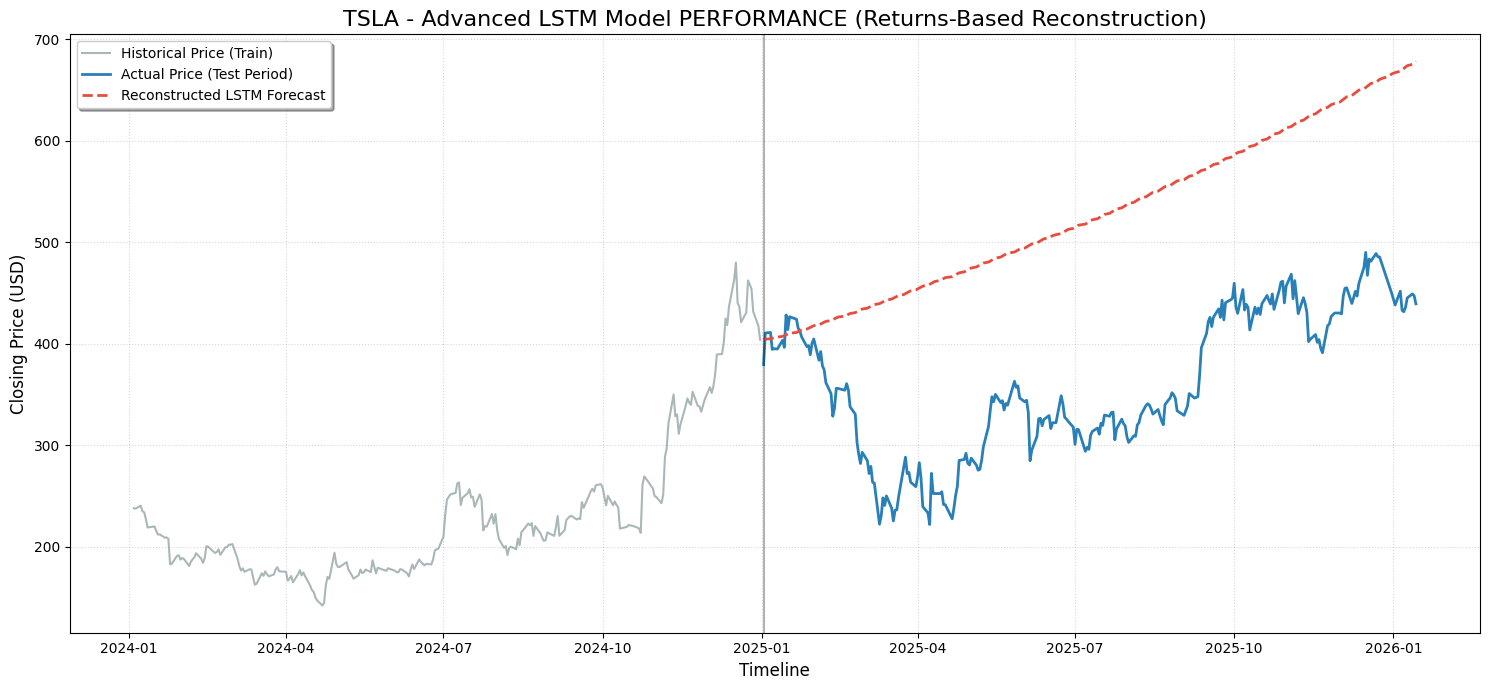

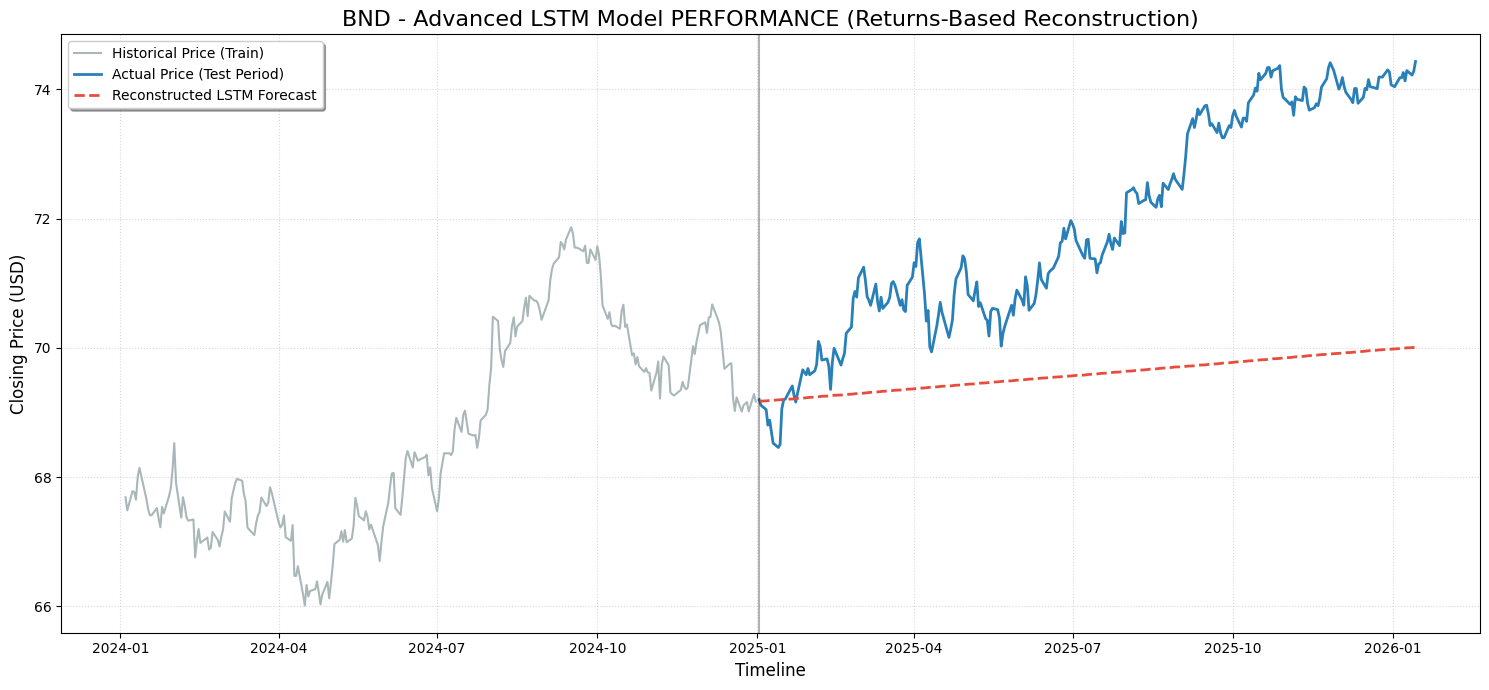

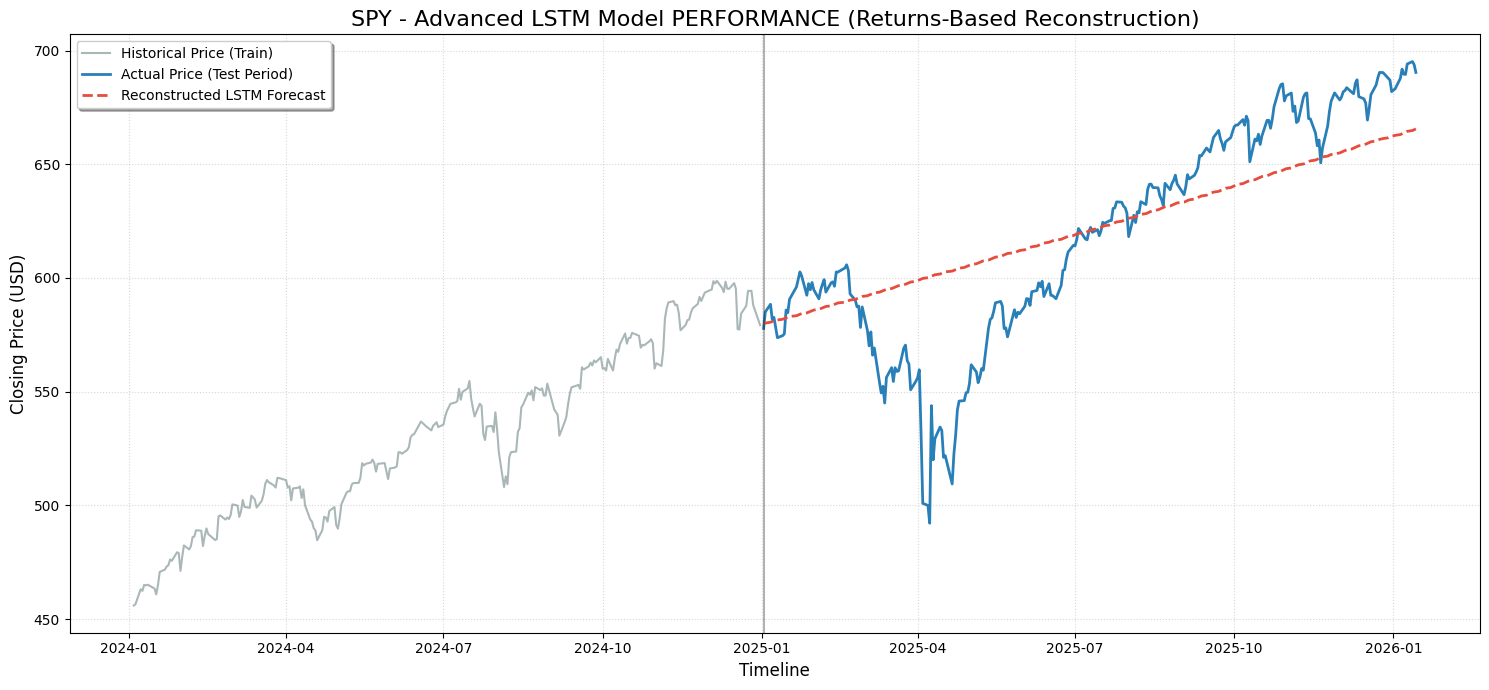

In [21]:
import matplotlib.pyplot as plt

def plot_advanced_lstm_results(ticker):
    # Retrieve data splits and the newly reconstructed price forecast
    train_data, test_data = splits[ticker]
    forecast = test_forecasts[ticker]
    
    plt.figure(figsize=(15, 7))
    
    # 1. Plot the historical background (more context: 250 days)
    plt.plot(train_data.index[-250:], train_data['Close'].tail(250), 
             label='Historical Price (Train)', color='#95a5a6', alpha=0.8, linewidth=1.5)
    
    # 2. Plot the Actual market movement
    plt.plot(test_data.index, test_data['Close'], 
             label='Actual Price (Test Period)', color='#2980b9', linewidth=2)
    
    # 3. Plot the Advanced LSTM Forecast
    plt.plot(forecast.index, forecast, 
             label='Reconstructed LSTM Forecast', color='#e74c3c', 
             linestyle='--', linewidth=2)
    
    # Formatting
    plt.title(f'{ticker} - Advanced LSTM Model PERFORMANCE (Returns-Based Reconstruction)', fontsize=16)
    plt.xlabel('Timeline', fontsize=12)
    plt.ylabel('Closing Price (USD)', fontsize=12)
    plt.legend(loc='upper left', frameon=True, shadow=True)
    plt.grid(True, which='both', linestyle=':', alpha=0.5)
    
    # Focus on the transition point
    plt.axvline(x=test_data.index[0], color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize for all assets
for asset in assets:
    plot_advanced_lstm_results(asset)